# SSD for VOC Object Detection

In [1]:
import os
import copy
from pathlib import Path
from functools import partial
from typing import Dict

import torch
from torch.utils.data import Dataset
from fastai.vision.all import (RandomSplitter, DataLoader,
                               DataLoaders, Learner, SaveModelCallback)

from models import SSD, generate_map_data, ssd_body_resnet50
from data_utils import BoxMatcher, VOCDataset, tensor2boxes, predict_image
from training import (loss_func, localization_loss_metric,
                      confidence_loss_metric, recall, precision)

torch.device('cuda')

device(type='cuda')

## Create DataLoaders

In [2]:
IMG_SIZE = 300
MATCH_THRESHOLD = 0.50
BATCH_SIZE = 32
NUM_ITERATIONS = 120_000

# The following values are derived from https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/Detection/SSD/src/utils.py
MAP_SIZES = [38, 19, 10, 5, 3, 1]
STEPS = [37.5, 18.75, 9.375, 4.6875, 3.0, 1.0]
SCALES = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
ASPECT_RATIOS = [[2], [2, 3], [2, 3], [2, 3], [2], [2]]

In [3]:
matcher = BoxMatcher(MAP_SIZES, STEPS, SCALES, ASPECT_RATIOS, MATCH_THRESHOLD)

## Load Data and Create DataLoaders

In [4]:
def get_voc_dataset(data_dir: Path, categories: Dict[int, str] = None, ignore_difficult: bool = False) -> Dataset:
    """Create a dataset object using data in the VOC challenge format"""
    IMG_DIR = data_dir / "JPEGImages"
    ANN_DIR = data_dir / "Annotations"
    ann_fns = [ANN_DIR / path for path in os.listdir(ANN_DIR)]
    
    voc_dataset = VOCDataset(ann_fns, IMG_DIR, IMG_SIZE, matcher, True, categories, ignore_difficult)
    
    return voc_dataset

# Initialize training set with VOC 2012 data and initialise empty validation
# set with identical categories
train_ds = get_voc_dataset(Path("./data/voc2012"))
voc2007 = get_voc_dataset(Path("./data/voc2007"), categories=train_ds.categories)
train_ds.data.extend(voc2007.data)

# Use 5% of training set for validation
valid_ds = copy.deepcopy(train_ds)
_, valid_idxs = RandomSplitter(0.05)(valid_ds.data)
valid_ds.data = [valid_ds.data[idx] for idx in valid_idxs]

train_ds.is_train = True
valid_ds.is_train = False

# Initialize the test set using VOC 2007
test_ds = get_voc_dataset(Path("./data/voc2007_test"), categories=train_ds.categories, ignore_difficult=True)
test_ds.is_train = False

In [5]:
# Create DataLoaders
train_dl = DataLoader(train_ds, bs=BATCH_SIZE, num_workers=32, drop_last=False, shuffle=True, pin_memory=True)
valid_dl = DataLoader(valid_ds, bs=BATCH_SIZE, num_workers=32, drop_last=False, shuffle=True, pin_memory=True)
dls = DataLoaders(train_dl, valid_dl)
dls.to(torch.device('cuda'))

Matched 11 default boxes in this image.


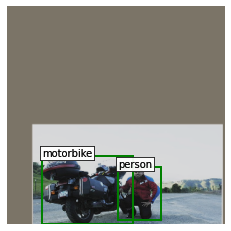

In [6]:
# Visualise Image in Training Dataset
img, targ = train_ds[0]
targ_boxes, targ_classes, _ = tensor2boxes(matcher.default_boxes, targ)
print(f"Matched {len(targ_boxes)} default boxes in this image.")
train_ds.show_img(img, (targ_boxes, targ_classes))

## Train Model

**Note:** the following models are available:
- Resnet18 (`from models import ssd_body_resnet18`)
- Resnet34 (`from models import ssd_body_resnet34`)
- Resnet50 (`from models import ssd_body_resnet50`)
- Resnet101 (`from models import ssd_body_resnet101`)
- Resnet152 (`from models import ssd_body_resnet152`)
- MobileNet v2 (`from models import ssd_body_mobilenet_v2`)

In [7]:
body = ssd_body_resnet50().cuda()
map_data = generate_map_data(IMG_SIZE, MAP_SIZES, body)
boxes_per_cell = [2 + 2*len(ratios) for ratios in ASPECT_RATIOS]
model = SSD(body, map_data, boxes_per_cell, train_ds.num_classes)
model = model.cuda()

In [8]:
learn = Learner(
    dls, model,
    loss_func=loss_func,
    metrics=[localization_loss_metric, confidence_loss_metric, recall, precision],
    model_dir='trained_models',
    cbs=[SaveModelCallback()],
    wd=5e-4,
)

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=0.0030199517495930195)

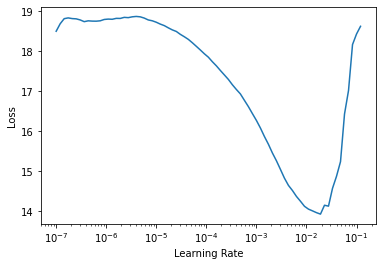

In [9]:
learn.lr_find()

In [10]:
learn.fit_one_cycle(300, lr_max=1e-3, div=100, wd=5e-4)
learn.save('final_model')

epoch,train_loss,valid_loss,localization_loss_metric,confidence_loss_metric,recall,precision,time
0,8.039210,7.558647,32.736622,75.729958,0.044560,0.147052,04:22
1,6.383162,6.343304,26.729803,66.142609,0.063603,0.231458,04:21
2,5.665462,5.601734,24.186625,59.964153,0.084758,0.331092,04:22
3,5.091310,4.914627,22.710520,53.328869,0.078991,0.494494,04:22
4,4.825455,4.533011,21.720591,49.805763,0.089688,0.573054,04:22
5,4.560578,4.270586,20.833382,47.053288,0.107750,0.606157,04:23
6,4.395963,4.047762,20.040421,44.918999,0.126178,0.680135,04:23
7,4.170501,3.849472,19.382109,42.902443,0.153908,0.685752,04:24
8,4.037648,3.695355,18.814911,41.182430,0.192857,0.689926,04:23
9,3.989670,3.613838,18.349846,40.222855,0.191946,0.707076,04:23


Better model found at epoch 0 with valid_loss value: 7.5586466789245605.
Better model found at epoch 1 with valid_loss value: 6.34330415725708.
Better model found at epoch 2 with valid_loss value: 5.601734161376953.
Better model found at epoch 3 with valid_loss value: 4.914626598358154.
Better model found at epoch 4 with valid_loss value: 4.533011436462402.
Better model found at epoch 5 with valid_loss value: 4.270586013793945.
Better model found at epoch 6 with valid_loss value: 4.047761917114258.
Better model found at epoch 7 with valid_loss value: 3.8494720458984375.
Better model found at epoch 8 with valid_loss value: 3.6953554153442383.
Better model found at epoch 9 with valid_loss value: 3.6138381958007812.
Better model found at epoch 10 with valid_loss value: 3.5080995559692383.
Better model found at epoch 11 with valid_loss value: 3.473015308380127.
Better model found at epoch 12 with valid_loss value: 3.36773419380188.
Better model found at epoch 13 with valid_loss value: 3.32

Path('trained_models/final_model.pth')

## Visualise Model Results

In [11]:
learn.load('model')
model = learn.model
model.eval();

/home/michael/anaconda3/envs/mlenv/lib/python3.8/site-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SSD(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, ke

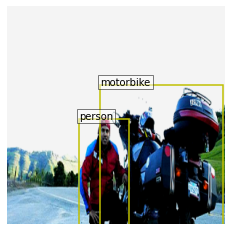

In [12]:
img, targ = train_ds[0]
targ_boxes, targ_classes, _ = tensor2boxes(matcher.default_boxes, targ)
pred_boxes, pred_classes, pred_confs = predict_image(model, img.cuda(), matcher.default_boxes.cuda(), conf_threshold = 0.50, iou_threshold = 0.45)
valid_ds.show_img(img, ([], []), (pred_boxes, pred_classes))

## Calculate mAP


AP for Person: 0.8073


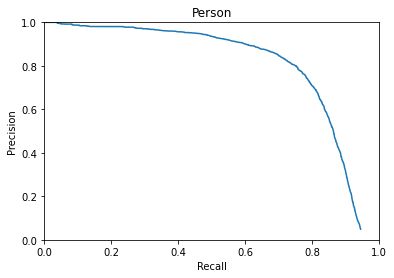


AP for Motorbike: 0.8509


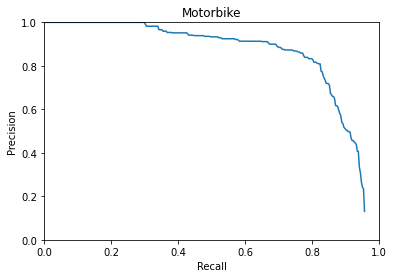


AP for Boat: 0.691


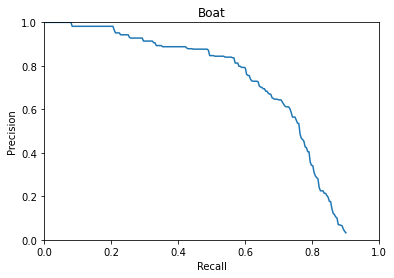


AP for Car: 0.8657


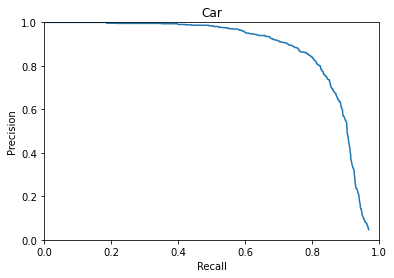


AP for Bottle: 0.4611


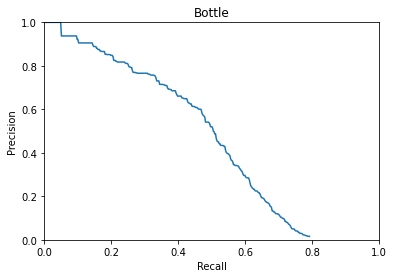


AP for Aeroplane: 0.8732


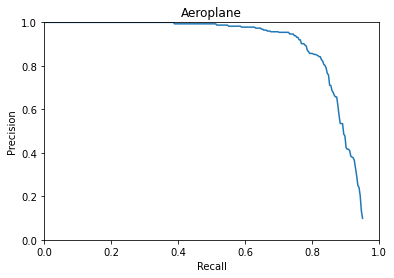


AP for Bird: 0.7803


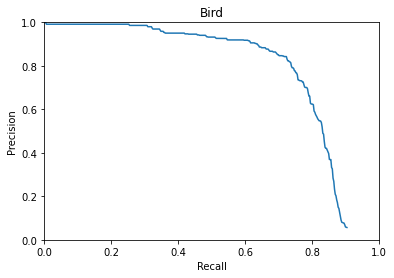


AP for Bus: 0.8649


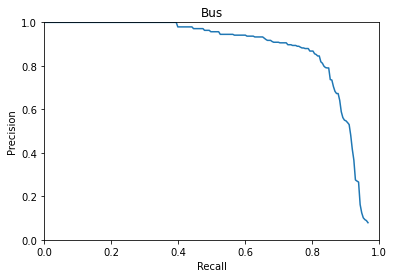


AP for Chair: 0.4641


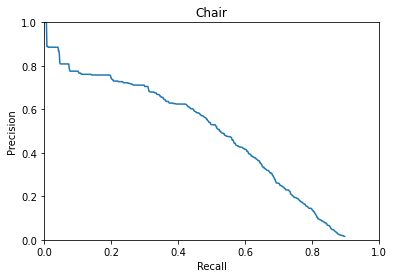


AP for Diningtable: 0.7101


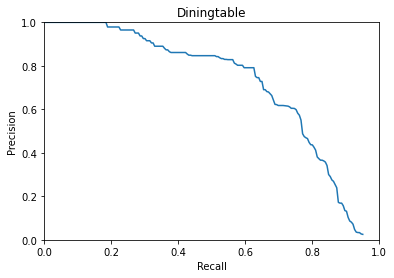


AP for Dog: 0.8503


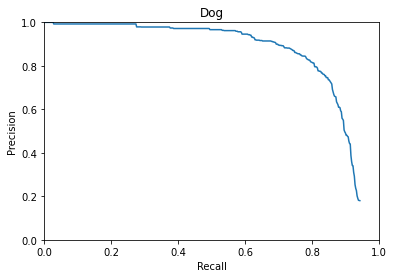


AP for Sofa: 0.7029


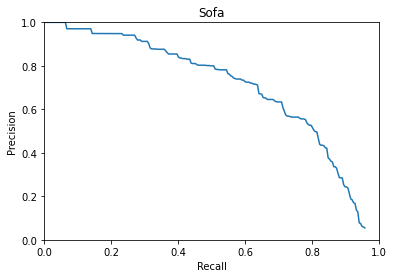


AP for Sheep: 0.8136


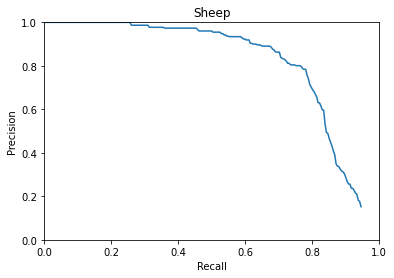


AP for Horse: 0.8428


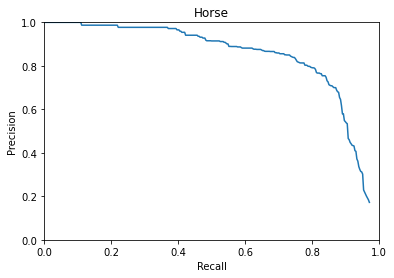


AP for Cow: 0.7858


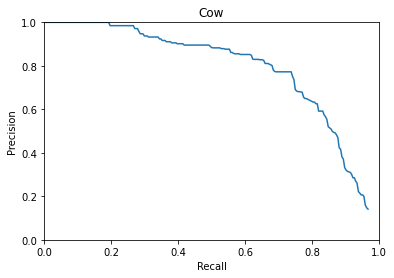


AP for Tvmonitor: 0.7441


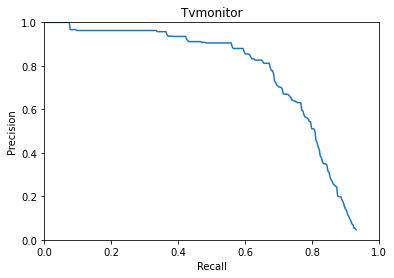


AP for Cat: 0.9145


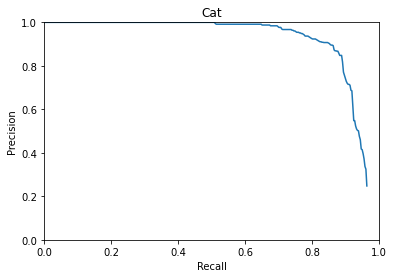


AP for Bicycle: 0.8397


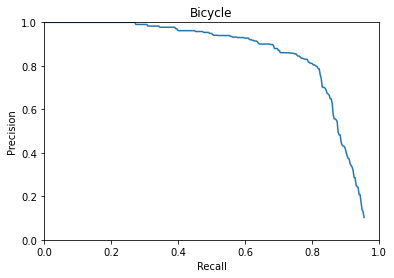


AP for Pottedplant: 0.4679


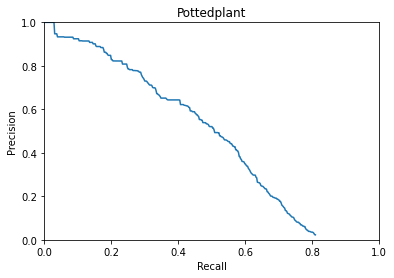


AP for Train: 0.9035


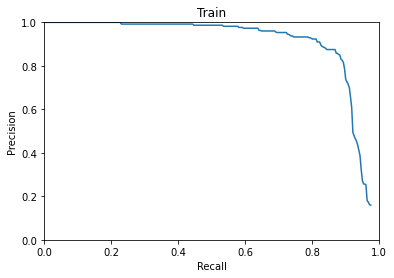

76.17 mAP


In [13]:
mean_avg_precision = test_ds.calculate_map(model)
print(f"{round(mean_avg_precision * 100, 2)} mAP")